<a href="https://colab.research.google.com/github/aviguptatx/SecretHitlerAI/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
    !pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1Bwd_Ma8mqCho0diPLoqPrLhsrAA77oEi'})
download.GetContentFile('games.zip')

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
!unzip "/content/gdrive/My Drive/Secret Hitler/games.zip"

Archive:  /content/gdrive/My Drive/Secret Hitler/games.zip
replace games/1.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import json
import random

LIB_CARDS_PER_DECK = 6
FAS_CARDS_PER_DECK = 11

def populate_inputs(game_number_start, game_number_end, lib_inc):
    # games[X][Y][Z] = [Game #][Gov #][Node in gov]
    games = []
    game_lengths = []
    # results[X][Y] = [Game #][Seat #]
    results = []
    game_numbers = []
    outed = []
    t = 0

    for lib_number in range(0, 4):
        for game_number in range(game_number_start, game_number_end):
            game_valid = True
            conflict = False
            game_data = []
            game_outed = [0] * 7

            # Length 7 = (1-7 roles)
            roles = []
            # Length 7: 1 denotes the lib seat the AI is
            my_role = [0] * 7

            file_name = "games/" + str(game_number) + ".json"

            lib_cards_played = 0
            fas_cards_played = 0

            lib_cards_deck = LIB_CARDS_PER_DECK
            fas_cards_deck = FAS_CARDS_PER_DECK

            with open(file_name) as f:
                data = json.load(f)

                # Check not custom
                if data["customGameSettings"]["enabled"]:
                    continue
                # Check if the game is 7 players
                if len(data["players"]) != 7:
                    continue
                # Check not rebalanced 7p
                if data["gameSetting"]["rebalance7p"]:
                    continue

                # Roles
                for seat in range(0, 7):
                    roles.append(1 if (data["players"][seat]["role"] == "fascist" or data["players"][seat]["role"] == "hitler") else 0)

                # Pick one of the liberals psuedorandomly (lib_inc is parameterized)
                lib_count = 0
                confirmed_seat = 0
                for seat in range(0, 7):
                    if data["players"][seat]["role"] == "liberal":
                        if lib_count == lib_number:
                            confirmed_seat = seat
                        lib_count = lib_count + 1

                # One-hot encode which seat the AI is playing
                my_role[confirmed_seat] = 1

                if len(data["logs"]) <= 4:
                    game_valid = False

                # Length 15 (1-7 - pres seat number) (8-14 - chancellor seat number) (15 - result)
                investigation_data = [0] * 15
                # Length 14 (1-7 - pres seat number) (1-7 - chancellor seat number)
                special_election_data = [0] * 14
                # Length 14 (1-7 - pres seat number) (1-7 - shot seat number)
                bullet_data_1 = [0] * 14
                # Length 14 (1-7 - pres seat number) (1-7 - shot seat number)
                bullet_data_2 = [0] * 14

                # For each government
                for gov in range(0, len(data["logs"])):
                    # # Length 15 (1-7 - pres seat number) (8-14 - chancellor seat number) (15 - result)
                    # investigation_data = [0] * 15
                    # # Length 14 (1-7 - pres seat number) (1-7 - chancellor seat number)
                    # special_election_data = [0] * 14
                    # # Length 14 (1-7 - pres seat number) (1-7 - shot seat number)
                    # bullet_data_1 = [0] * 14
                    # # Length 14 (1-7 - pres seat number) (1-7 - shot seat number)
                    # bullet_data_2 = [0] * 14
                    
                    gov_valid = False

                    # Lenth 42 (1-7 - pres, 8-14 chanc, 15-18 pres claim, 19-21 chanc claim, 22 policy not enacted, 23 blue, 24 red, 25-30 num blue played, 31-37 num red played, 38-44 vote data)
                    gov_data = []
                    topdecks = []

                    # If the government was played
                    if len(data["logs"][gov]) >= 7:
                        gov_valid = True

                        # President seat number
                        for pres in range(0, 7):
                            gov_data.append(1 if data["logs"][gov]["presidentId"] == pres else 0)

                        # Chancellor seat number
                        for chan in range(0, 7):
                            gov_data.append(1 if data["logs"][gov]["chancellorId"] == chan else 0)

                        pres_claim = data["logs"][gov]["presidentClaim"]["reds"] if "presidentClaim" in data["logs"][gov] else -1
                        chanc_claim = data["logs"][gov]["chancellorClaim"]["reds"] if "chancellorClaim" in data["logs"][gov] else -1

                        # President number of reds claimed
                        if "presidentClaim" in data["logs"][gov]:
                            gov_data.append(1 if pres_claim == 0 else 0)
                            gov_data.append(1 if pres_claim == 1 else 0)
                            gov_data.append(1 if pres_claim == 2 else 0)
                            gov_data.append(1 if pres_claim == 3 else 0)
                        elif "chancellorClaim" in data["logs"][gov]:
                            pres_claim = chanc_claim + 1
                            gov_data.append(0)
                            gov_data.append(1 if chanc_claim == 0 else 0)
                            gov_data.append(1 if chanc_claim == 1 else 0)
                            gov_data.append(1 if chanc_claim == 2 else 0)
                        elif "enactedPolicy" in data["logs"][gov]:
                            # game_valid = False
                            gov_data.append(0)
                            gov_data.append(0)
                            gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                            gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                        else:
                            game_valid = False

                        # Chancellor number of reds claimed
                        if "chancellorClaim" in data["logs"][gov]:
                            gov_data.append(1 if chanc_claim == 0 else 0)
                            gov_data.append(1 if chanc_claim == 1 else 0)
                            gov_data.append(1 if chanc_claim == 2 else 0)
                        elif "presidentClaim" in data["logs"][gov]:
                            if ("enactedPolicy" in data["logs"][gov] and data["logs"][gov]["enactedPolicy"] == "fascist"):
                                chanc_claim = 2
                                gov_data.append(0)
                                gov_data.append(0)
                                gov_data.append(1)
                            else:
                                chanc_claim = min(0, pres_claim - 1)
                                gov_data.append(1 if chanc_claim == 0 else 0)
                                gov_data.append(1 if chanc_claim == 1 else 0)
                                gov_data.append(0)
                        elif "enactedPolicy" in data["logs"][gov]:
                            # game_valid = False
                            gov_data.append(0)
                            gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                            gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                        else:
                            game_valid = False

                        # Encode card outed
                        if (confirmed_seat == data["logs"][gov]["presidentId"] or confirmed_seat == data["logs"][gov]["chancellorId"]) and (pres_claim - chanc_claim != 1 and pres_claim != 0) and "enactedPolicy" in data["logs"][gov] and data["logs"][gov]["enactedPolicy"] == "fascist":
                            game_outed[data["logs"][gov]["chancellorId" if confirmed_seat == data["logs"][gov]["presidentId"] else "presidentId"]] = 1
                            conflict = True
                            
                        # No policy enacted?
                        gov_data.append(0 if "enactedPolicy" in data["logs"][gov] else 1)

                        # Red enacted?, blue enacted?
                        if "enactedPolicy" in data["logs"][gov]:
                            gov_data.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                            gov_data.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                            if data["logs"][gov]["enactedPolicy"] == "fascist":
                                fas_cards_played += 1
                            else:
                                lib_cards_played += 1
                        else:
                            gov_data.append(0)
                            gov_data.append(0)

                        for seat in range(0, 7):
                          gov_data.append(1 if data["logs"][gov]["votes"][seat] else 0)
                        
                        # If investigation
                        if "investigationId" in data["logs"][gov]:
                            investigation_data[data["logs"][gov]["presidentId"]] = 1
                            investigation_data[7 + data["logs"][gov]["investigationId"]] = 1
                            if not "investigationClaim" in data["logs"][gov]:
                                game_valid = False
                            else:
                                investigation_data[14] = 1 if data["logs"][gov]["investigationClaim"] == "fascist" else 0

                        # Encode inv outed
                        if "investigationId" in data["logs"][gov] and (confirmed_seat == data["logs"][gov]["presidentId"] or confirmed_seat == data["logs"][gov]["investigationId"]) and "investigationClaim" in data["logs"][gov] and data["logs"][gov]["investigationClaim"] == "fascist":
                            game_outed[data["logs"][gov]["investigationId" if confirmed_seat == data["logs"][gov]["presidentId"] else "presidentId"]] = 1
                            conflict = True
                        
                        # If Special Election
                        if "specialElection" in data["logs"][gov]:
                            special_election_data[data["logs"][gov]["presidentId"]] = 1
                            special_election_data[7 + data["logs"][gov]["presidentId"]] = 1
                            
                        # If bullet
                        if "execution" in data["logs"][gov]:
                            # If first bullet
                            if not 1 in bullet_data_1:
                                # President Id
                                bullet_data_1[data["logs"][gov]["presidentId"]] = 1
                                # Chancellor Id
                                bullet_data_1[7 + data["logs"][gov]["execution"]] = 1
                            # If second bullet
                            else:
                                # President Id
                                bullet_data_2[data["logs"][gov]["presidentId"]] = 1
                                # Chancellor Id
                                bullet_data_2[7 + data["logs"][gov]["execution"]] = 1

                    # If the government was a topdeck
                    if len(data["logs"][gov]) == 4 and ("enactedPolicy" in data["logs"][gov]):
                        gov_valid = True
                        topdecks.append(0)
                        topdecks.append(0 if data["logs"][gov]["enactedPolicy"] == "fascist" else 1)
                        topdecks.append(1 if data["logs"][gov]["enactedPolicy"] == "fascist" else 0)
                    else:
                        topdecks.append(1)
                        topdecks.append(0)
                        topdecks.append(0)

                    # If hitler was elected
                    if len(data["logs"][gov]) == 3 and gov == (len(data["logs"]) - 1) and data["players"][data["logs"][gov]["chancellorId"]]["role"] == "hitler":
                        game_outed[data["logs"][gov]["chancellorId"]] = 1
                        t += 1

                    # Fill empty data with 0s
                    for i in range(len(gov_data), 31):
                        gov_data.append(0)
                    for i in range(len(investigation_data), 15):
                        investigation_data.append(0)
                    for i in range(len(special_election_data), 14):
                        special_election_data.append(0)
                    for i in range(len(bullet_data_1), 14):
                        bullet_data_1.append(0)
                    for i in range(len(bullet_data_2), 14):
                        bullet_data_2.append(0)

                    if gov_valid:
                        game_data.append(gov_data + investigation_data + special_election_data + bullet_data_1 + bullet_data_2 + topdecks + my_role + game_outed)

                if game_valid:
                    game_lengths.append(len(game_data))

                for i in range(len(game_data), 12):
                    game_data.append([0] * 105)

                if game_valid:
                    games.append(game_data)
                    results.append(roles)
                    game_numbers.append(game_number)
                    outed.append(game_outed)


    # Remove games with fake conflicts
    for t in range(len(games) - 1, -1, -1):
        for seat in range(7):
            if (outed[t][seat] == 1 and results[t][seat] == 0):
                del games[t]
                del results[t]
                del game_numbers[t]
                del game_lengths[t]
                del outed[t]
                break

    print(t/4)
    return games, results, game_numbers, game_lengths, outed

In [0]:
 # Write all of the above information for a single hyperparameter setup into a csv file
file_hypers = open("Hyperparameter_Setups.csv", "w+")
file_hypers.write("Hidden Nodes,Num Epochs,Learning Rate,Weight Decay,,Half Train Seat Error,Half Validation Seat Error,Half Validation Rounded Error,Half Validation Sorted Error,,Train Seat Error,Validation Seat Error,Validation Rounded Error,Validation Sorted Error\n")
file_hypers.close()

Streaming output truncated to the last 5000 lines.
Game #22979
Pred: tensor([0.3432, 0.4520, 0.3910, 0.0123, 0.5782, 0.6090, 0.6849],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Game #22980
Pred: tensor([0.5526, 0.2453, 0.4915, 0.3514, 0.4352, 0.0098, 0.7780],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Game #22981
Pred: tensor([0.3374, 0.7685, 0.9700, 0.2637, 0.3050, 0.2706, 0.0011],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Game #22982
Pred: tensor([0.1442, 0.4264, 0.6664, 0.8267, 0.0499, 0.8232, 0.0173],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Game #22983
Pred: tensor([0.6332, 0.4727, 0.0751, 0.9469, 0.2906, 0.4330, 0.0089],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Game #22984
Pred: t

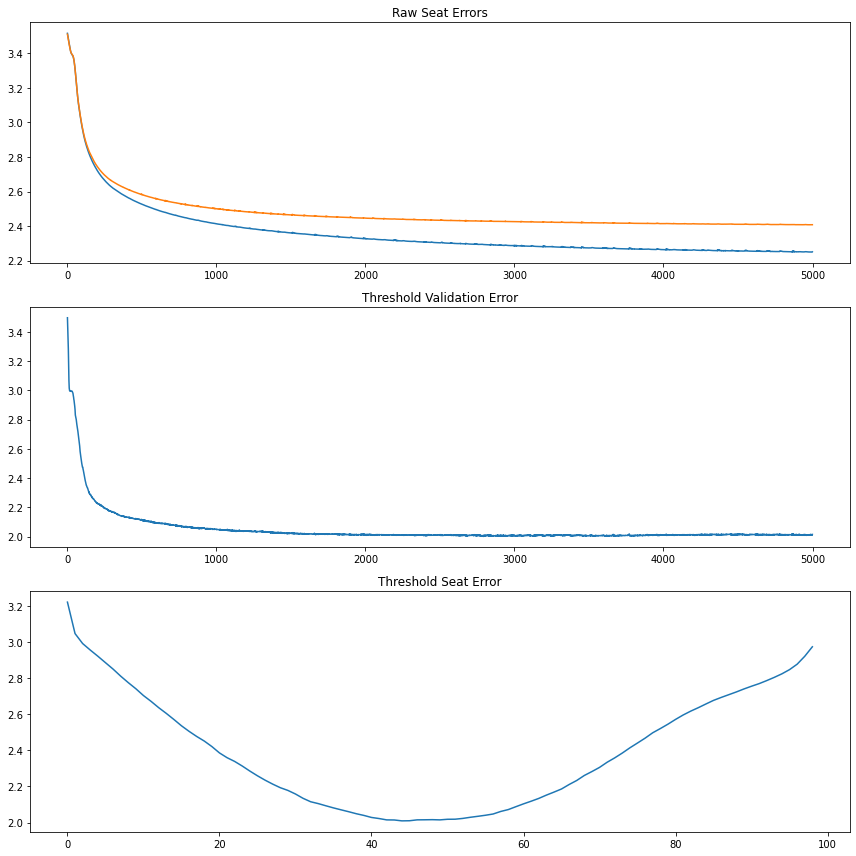

Streaming output truncated to the last 5000 lines.
Game #22979
Pred: tensor([0.3494, 0.6332, 0.3964, 0.0348, 0.6945, 0.5041, 0.5489],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Game #22980
Pred: tensor([0.5583, 0.3337, 0.4743, 0.4723, 0.2434, 0.0083, 0.7636],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Game #22981
Pred: tensor([0.3256, 0.6162, 0.9111, 0.3450, 0.2671, 0.3698, 0.0071],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Game #22982
Pred: tensor([0.3087, 0.5363, 0.7586, 0.5223, 0.0729, 0.8716, 0.0090],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Game #22983
Pred: tensor([0.5009, 0.3227, 0.1520, 0.9744, 0.3684, 0.3397, 0.0219],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Game #22984
Pred: t

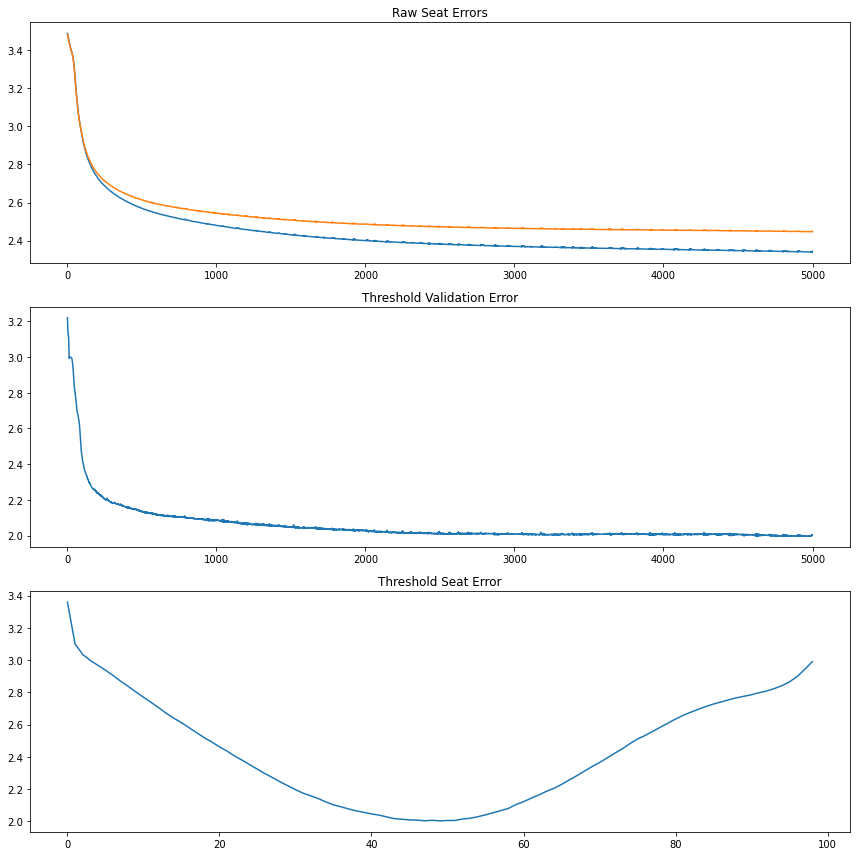

Streaming output truncated to the last 5000 lines.
Game #22979
Pred: tensor([0.4616, 0.5553, 0.6659, 0.0116, 0.5334, 0.4440, 0.4473],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Game #22980
Pred: tensor([0.4316, 0.2441, 0.6327, 0.2316, 0.5317, 0.0091, 0.7368],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Game #22981
Pred: tensor([0.4890, 0.5453, 0.9224, 0.3401, 0.3691, 0.2449, 0.0037],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Game #22982
Pred: tensor([0.2955, 0.6166, 0.8096, 0.4798, 0.1115, 0.7068, 0.0068],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Game #22983
Pred: tensor([0.6619, 0.2774, 0.2319, 0.9334, 0.4262, 0.2384, 0.0079],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Game #22984
Pred: t

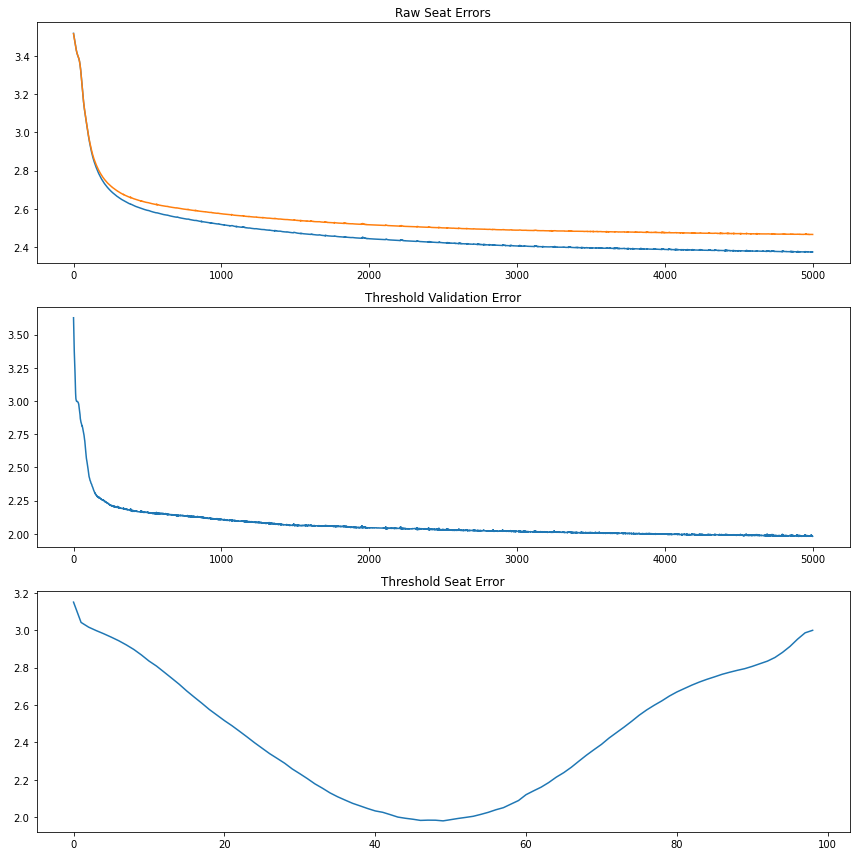

Streaming output truncated to the last 5000 lines.
Game #22979
Pred: tensor([0.4734, 0.5441, 0.4712, 0.0168, 0.4383, 0.5708, 0.5975],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Game #22980
Pred: tensor([0.5490, 0.1310, 0.4528, 0.4973, 0.5109, 0.0115, 0.7834],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Game #22981
Pred: tensor([0.4455, 0.5556, 0.9185, 0.3689, 0.4086, 0.3252, 0.0051],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Game #22982
Pred: tensor([0.2124, 0.5908, 0.6070, 0.5452, 0.2421, 0.7576, 0.0115],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Game #22983
Pred: tensor([0.5879, 0.2376, 0.1963, 0.9368, 0.3770, 0.3226, 0.0073],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Game #22984
Pred: t

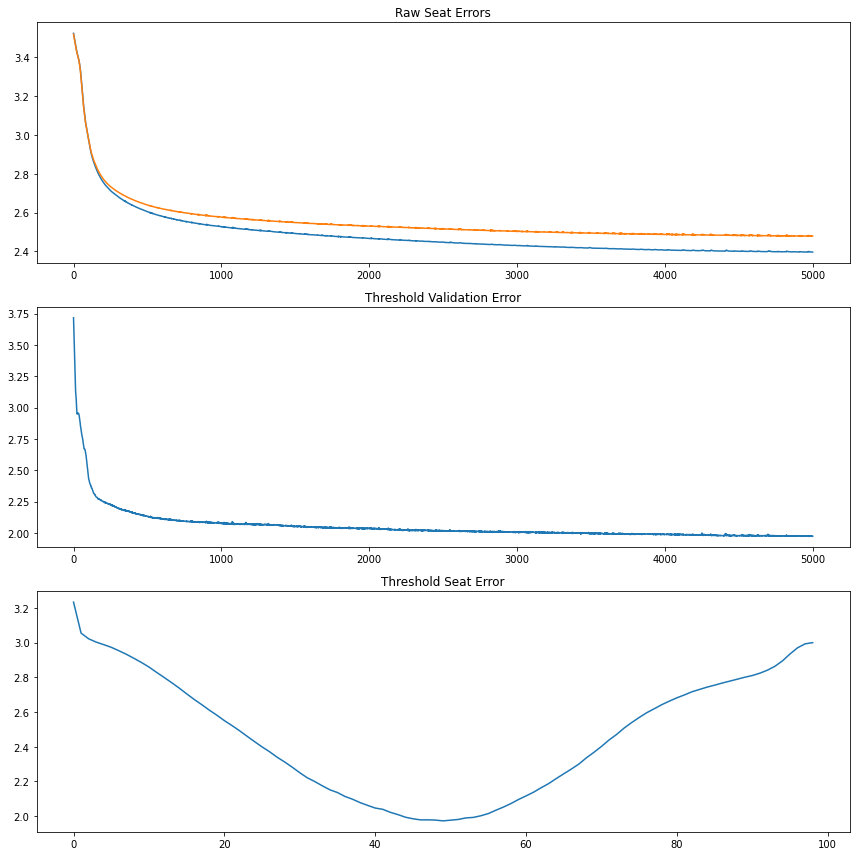

Streaming output truncated to the last 5000 lines.
Game #22979
Pred: tensor([0.3820, 0.4837, 0.5286, 0.0313, 0.5573, 0.5845, 0.5568],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Game #22980
Pred: tensor([0.4891, 0.2989, 0.4642, 0.3793, 0.4105, 0.0141, 0.7636],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 0, 1, 0, 1, 0, 1], device='cuda:0')
Game #22981
Pred: tensor([0.4168, 0.5724, 0.9106, 0.3150, 0.3107, 0.3561, 0.0060],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 1, 0, 0, 0], device='cuda:0')
Game #22982
Pred: tensor([0.5961, 0.4443, 0.6478, 0.4979, 0.2312, 0.7168, 0.0104],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([0, 1, 1, 0, 0, 1, 0], device='cuda:0')
Game #22983
Pred: tensor([0.5424, 0.3031, 0.1299, 0.9343, 0.3429, 0.3360, 0.0276],
       device='cuda:0', grad_fn=<SelectBackward>)
Real: tensor([1, 0, 0, 1, 1, 0, 0], device='cuda:0')
Game #22984
Pred: t

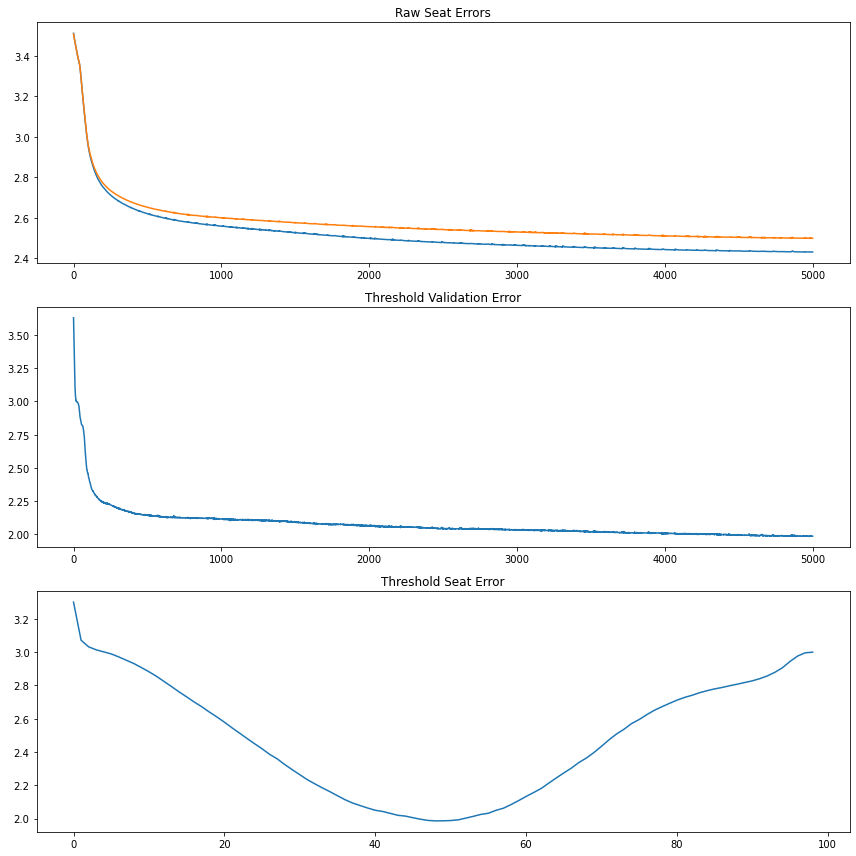

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import gc
import sys

# Prints the entire numpy array
np.set_printoptions(threshold=sys.maxsize)

# Deterministic randomness
torch.manual_seed(0)

# Garbage collect
gc.collect()

# Enables device agnostic tensor creation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Empty the CUDA cache
with torch.no_grad():
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

# Recurrent Neural Network
class RNN(nn.Module):
    def __init__(self, n_inputs, n_neurons, X_in, seq_lengths):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(n_inputs, n_neurons, batch_first=True, num_layers=1, dropout=0)
        self.n_neurons = n_neurons
        self.X = X_in
        self.seq_lengths = seq_lengths
        self.FC = nn.Linear(self.n_neurons, 7)
    def forward(self):
        # Initialize the hidden state with all zeroes
        self.init_hidden()
        # Pack X
        self.X_packed = torch.nn.utils.rnn.pack_padded_sequence(Variable(self.X), self.seq_lengths, batch_first=True, enforce_sorted=False)
        # Calculate values of hidden states
        _, self.hx = self.rnn(self.X_packed)
        # Run the states through the sigmoid function
        sigmoid = nn.Sigmoid()
        out = sigmoid(self.FC(self.hx[0][0])).to(device)

        return out
    def init_hidden(self):
        self.hx = Variable(torch.zeros(1, len(self.X), self.n_neurons).to(device))

# Number of nodes in input layer
N_INPUT = 105

# Number of games
N_GAMES = 25000

# Training set
X, Y, train_game_numbers, train_seq_lengths, train_outed = populate_inputs(2, int(N_GAMES * 0.8), 1)

# Validation set
validation_X, validation_Y, validation_game_numbers, validation_seq_lengths, validation_outed = populate_inputs(int(N_GAMES * 0.8), int(N_GAMES * 1), 1)


# Testing set
test_X, test_Y, _, test_seq_lengths, _ = populate_inputs(int(N_GAMES * 0.8), N_GAMES - 1, 1)

# Convert to tensors
X = torch.as_tensor(X, dtype=torch.float32).to(device)
Y = torch.as_tensor(Y).to(device)
validation_X = torch.as_tensor(validation_X, dtype=torch.float32).to(device)
validation_Y = torch.as_tensor(validation_Y).to(device)
test_X = torch.as_tensor(test_X, dtype=torch.float32).to(device)
test_Y = torch.as_tensor(test_Y).to(device)

# Hyperparameters
N_EPOCHS = 5000
# LEARNING_RATE = .01
# LAMBDA_ = 0.0012
# N_NEURONS = 40

lr_array = [0.0015]
lambda_array = [.0002, .0003, .0004, .0005, .0006]
n_neurons_array = [22]

# Grid search
for LEARNING_RATE in lr_array:
    for LAMBDA_ in lambda_array:
        for N_NEURONS in n_neurons_array:
            # Saves and loads parameters depending on these values
            LOAD_PARAMS = False
            TESTING = False

            # Training model
            train_model = RNN(N_INPUT, N_NEURONS, X, train_seq_lengths).to(device)

            # Validation model
            validation_model = RNN(N_INPUT, N_NEURONS, validation_X, validation_seq_lengths).to(device)

            # Test model
            test_model = RNN(N_INPUT, N_NEURONS, test_X, test_seq_lengths).to(device)

            # Load parameters if requested
            if LOAD_PARAMS:
                train_model.load_state_dict(torch.load('parameters-saved'))

            # Set the loss function to binary cross entropy and use Adam optimizer
            criterion = nn.BCELoss().to(device)
            optimizer = optim.Adam(train_model.parameters(), lr=LEARNING_RATE, weight_decay=LAMBDA_)

            # Training metrics
            train_seat_errors = []

            # Validation metrics
            validation_seat_errors = []
            rounded_validation_seat_errors = []
            sorted_validation_seat_errors = []
            threshold_validation_seat_errors = []

            # Test set
            if TESTING:
                test_model.load_state_dict(torch.load('parameters-saved'))

                # Run testing metrics
                prediction = test_model()

                # Store the errors for the test set
                test_seat_error = torch.sum(torch.abs(test_Y - prediction)) / len(test_Y)

                # Store the errors for the test set, but round to either 0 or 1
                rounded_test_seat_error = torch.sum(torch.abs(test_Y - torch.round(prediction))) / len(test_Y)

                # Assume the 3 highest values are fascist and the rest are lib
                _, sorted_test_seat_indices = torch.sort(prediction)
                sorted_prediction = torch.zeros(prediction.size()).to(device)
                for i in range(5, 7):
                    for game in range(len(test_X)):
                        sorted_prediction[0][game][sorted_test_seat_indices[0][game][i]] = 1
                sorted_test_seat_error = torch.sum(torch.abs(test_Y - sorted_prediction)) / len(test_Y)

                # Data after all epochs
                print("Test error: " + str(test_seat_error))
                print("Test error with threshold: " + str(rounded_test_seat_error))
                print("Test error with sort: " + str(sorted_test_seat_error))

            # Training
            else:
                for epoch in range(N_EPOCHS):
                    # Print the epoch number every 100 epochs
                    if epoch % 100 == 0:
                        print("Epoch " + str(epoch))

                    train_model.train()
                    validation_model.train()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # reset hidden states
                    train_model.init_hidden()
                    validation_model.init_hidden()

                    # Run the model, collect states (store them)
                    last_states = train_model()

                    # Calculate loss and backpropogate
                    loss = criterion(last_states.float(), Y.float())

                    loss.backward()
                    optimizer.step()

                    # Evaluate the training set errors and store them
                    train_seat_error = torch.sum(torch.abs(Y - last_states)) / len(Y)
                    train_seat_errors.append(train_seat_error.detach().item())
                    
                    train_model.eval()

                    # Transfer weights of training model to the validation model for validation
                    torch.save(train_model.state_dict(), 'parameters-transfer')
                    validation_model.load_state_dict(torch.load('parameters-transfer'))
                    
                    # Run the validation model on the validation data set and store predictions
                    prediction = validation_model()

                    # Store the errors for the validation set
                    validation_seat_error = torch.sum(torch.abs(validation_Y - prediction)) / len(validation_Y)
                    validation_seat_errors.append(validation_seat_error.detach().item())

                    # Store the errors for the validation set, but round to either 0 or 1
                    rounded_validation_seat_error = torch.sum(torch.abs(validation_Y - torch.round(prediction))) / len(validation_Y)
                    rounded_validation_seat_errors.append(rounded_validation_seat_error.detach().item())

                    # If this is the middle or last epoch
                    if (epoch + 1) % (N_EPOCHS / 2) == 0:

                        # Assume the 3 highest values are fascist and the rest are lib
                        _, sorted_validation_seat_indices = torch.sort(prediction)
                        sorted_prediction = torch.zeros(prediction.size()).to(device)
                        for i in range(5, 7):
                            for game in range(len(validation_X)):
                                sorted_prediction[game][sorted_validation_seat_indices[game][i]] = 1
                        sorted_validation_seat_error = torch.sum(torch.abs(validation_Y - sorted_prediction)) / len(validation_Y)
                        sorted_validation_seat_errors.append(sorted_validation_seat_error.detach().item())

                    validation_model.eval()

            # Save the trained parameters
            if not TESTING:
                torch.save(train_model.state_dict(), 'parameters-saved')

            # Graph error vs threshold
            min_threshold_error = 10
            min_threshold_val = -1
            for threshold in range(49, -50, -1):
                threshold_seat_error = torch.sum(torch.abs(validation_Y - torch.round(prediction + .01 * threshold))) / len(validation_Y)
                cur_threshold_error = threshold_seat_error.detach().item()

                if cur_threshold_error < min_threshold_error:
                    min_threshold_error = cur_threshold_error
                    min_threshold_val = threshold

                threshold_validation_seat_errors.append(cur_threshold_error)

            # Print validation set results
            print("\nValidation Set Data")
            for game_index in range(len(validation_X)):
                print("Game #" + str(validation_game_numbers[game_index]))
                print("Pred: " + str(prediction[game_index]) + "\nReal: " + str(validation_Y[game_index]))

            # Print hyperparameters
            print("\n" + '\033[1m' + "Hyperparameters")
            print('\033[21m' + "Number of Epochs:               " + str(N_EPOCHS))
            print("Learning rate:                  " + str(lr_array[0]))
            print("Lambda:                         " + str(lambda_array[0]))
            print("Number of Hidden Nodes:         " + str(n_neurons_array[0]))
            print("Number of Input Nodes:          " + str(N_INPUT))
            
            print("\n" + '\033[1m' + "Custom Metrics")

            # Print the average conflict confidence on the training set
            sum = 0
            count = 0
            for game in range(len(train_outed)):
                for seat_number in range(7):
                    if (train_outed[game][seat_number]):
                        count += 1
                        sum += last_states[game][seat_number]
            print('\033[21m' + "Training Conflict Confidence:   " + "%.4f" % (sum / count))

            # Print the average conflict confidence on the validation set
            sum = 0
            count = 0
            correct = 0
            for game in range(len(validation_outed)):
                for seat_number in range(7):
                    if (validation_outed[game][seat_number]):
                        count += 1
                        correct += prediction[game][seat_number] > .5
                        sum += prediction[game][seat_number]
            print("Validation Conflict Confidence: " + "%.4f" % (sum / count))
            print("Validation Conflict Percent Correct: " + "%.4f" % (100 * correct / count))
              
            # Data after half of the epochs
            print("\n" + '\033[1m' + "Halfway")
            print('\033[21m' + "Train error: " + "                      %.4f" % train_seat_errors[int(-N_EPOCHS / 2)])
            print("Validation error: " + "                 %.4f" % validation_seat_errors[int(N_EPOCHS / 2)])
            print("Validation error with threshold: " + "  %.4f" % rounded_validation_seat_errors[int(N_EPOCHS / 2)])
            print("Validation error with sort: " + "       %.4f" % sorted_validation_seat_errors[-2])

            # Data after all epochs
            print("\n" + '\033[1m' + "End")
            print('\033[21m' + "Train error: " + "                      %.4f" % train_seat_errors[-1])
            print("Validation error: " + "                 %.4f" % validation_seat_errors[-1])
            print("Validation error with threshold: " + "  %.4f" % rounded_validation_seat_errors[-1])
            print("Validation error with sort: " + "       %.4f" % sorted_validation_seat_errors[-1])

            # Most optimal threshold data
            print("\nOptimal Threshold: " + "                %.4f" % (min_threshold_val * -.01 + .5))
            print("Optimal Threshold Error: " + "          %.4f" % min_threshold_error)

            # Write all of the above information for a single hyperparameter setup into a csv file
            file_hypers = open("Hyperparameter_Setups.csv", "a+")

            # Write the current results (for this hyperparameter setup)
            file_hypers.write("%.04f" % N_NEURONS + "," + "%.04f" % N_EPOCHS + "," + "%.04f" % LEARNING_RATE + "," + "%.04f" % LAMBDA_ + ",," + 
                              "%.04f" % train_seat_errors[int(-N_EPOCHS / 2)] + "," + "%.04f" % validation_seat_errors[int(N_EPOCHS / 2)] + "," + 
                                "%.04f" % rounded_validation_seat_errors[int(N_EPOCHS / 2)] + "," + "%.04f" % sorted_validation_seat_errors[-2] + ",," + 
                              "%.04f" % train_seat_errors[-1] + "," + "%.04f" % validation_seat_errors[-1] + "," + 
                                "%.04f" % rounded_validation_seat_errors[-1] + "," + "%.04f" % sorted_validation_seat_errors[-1] + "\n")
            file_hypers.close()

            plt.rcParams['figure.figsize'] = [12, 12]

            # Graph Train Error
            plt.subplot(3, 1, 1)
            plt.title("Raw Seat Errors")
            plt.plot(train_seat_errors)
            plt.plot(validation_seat_errors)

            # # Graph Validation Error
            # plt.subplot(3, 1, 2)
            # plt.title("Validation Error")
            # plt.plot(validation_seat_errors)

            # Graph validation set error
            plt.subplot(3, 1, 2)
            plt.title("Threshold Validation Error")
            plt.plot(rounded_validation_seat_errors)

            # Graph Validation Threshold Error
            plt.subplot(3, 1, 3)
            plt.title("Threshold Seat Error")
            plt.plot(threshold_validation_seat_errors)

            # Pad graphs so the titles and graphs don't overlap
            plt.tight_layout()

            # Show plot
            plt.show()
 